In [1]:
import pandas as pd
import numpy as np

# Decision Trees

**Decision Tree** is a popular supervised learning algorithm known for its high interpretability. Decision Tree models are considered to have low computational cost in comparison to many other algorithms, but Decision Trees are [non parametric](https://sebastianraschka.com/faq/docs/parametric_vs_nonparametric.html) which means their [computational cost](https://www.thekerneltrip.com/machine/learning/computational-complexity-learning-algorithms/) (can) grow as the size of the dataset increases.

## Pros & Cons

### Pros

- Easy to explain and visualize
- Irrelevant features will not be used by the model (built in feature selection)
    - Decision Trees can be used to identify the predictive power of features with non-linear relationships! More [here](https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598)
- Preprocessing needs are minimal
    - Scaling doesn't have a high impact on results.
    - Multicollinearity doesn't impact results.
    - Outliers have a low impact on results.
- Very fast prediction speed

### Cons

- High variability (Easily overfits to data)

### Pro + Con

- Decision Trees have a lot of tuning options (hyper parameters)
    - Pro
        - Models can be highly customizable and optimized!
    - Con
        - There is a learning curve to using these tuning options. 

## What is a decision tree?

A decision tree filters the data according to a series of `if` and `else` statements. 

<img src="simple_example.png" style="height:300px;">

Above is an extremely simple example of a decision tree, let's look at an example that is a little more complicated. 

**Say we have an unorganized drawer of pens and pencils. The pens and pencils are made with the following materials:**

<img src="writing_utensils.png" style="width:600px;">

In the cell below, we import data for this drawer:
> For the type column, 0 = pencil and 1 = pen

In [2]:
utensils = pd.read_csv('writing_utensils.csv')
utensils.head()

,wood,metal,plastic,has_cap,type
0,0,1,0,0,1
1,0,1,0,0,1
2,1,0,0,0,0
3,0,1,0,0,1
4,0,0,1,1,1


Whenever we are doing a classification problem, one of the first things we should check is the distribution of the classification column. We can do this by running `.value_counts()` on this column.

In [3]:
utensils.type.value_counts(normalize=True)

0    0.52
1    0.48
Name: type, dtype: float64

The data is very close to evenly split. That's a good thing!

If we group by `type` we can look at the joint probabilities for pens and pencils:

In [4]:
utensils.groupby('type').sum()

,wood,metal,plastic,has_cap
type,,,,
0,15,4,7,0
1,0,15,9,9


In [5]:
utensils.shape[0]

50

**Using the table above, what observations can we make about the pens and pencils in our drawer?**

1.   
2.   
3.  

In [6]:
from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vRjpSr7iFUUJLV8RrrLtBF3czpuhV4iKnAylzbhDLlrvYirUO6hmNxyEerJjC8uTyIbA8WpDN1ZvnHR/embed?start=false&loop=false&delayms=3000" frameborder="0" width="960" height="400" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Let's code out our decision tree!

In [8]:
# Your code here
from sklearn.metrics import accuracy_score

preds = []
for idx, row in utensils.iterrows():
    if row.wood:
        preds.append(0)
    elif row.has_cap:
        preds.append(1)
    elif row.metal:
        preds.append(1)
    else:
        preds.append(0)

accuracy_score(utensils.type, preds)

0.92

**What observations did we classify incorrectly?**

In [9]:
# Your code here
utensils[utensils.type != preds]

,wood,metal,plastic,has_cap,type
35,0,1,0,0,0
41,0,1,0,0,0
42,0,1,0,0,0
44,0,1,0,0,0


**How can we do this with sklearn?**

In [3]:
from sklearn.tree import DecisionTreeClassifier

X = utensils.drop('type', axis=1)
y = utensils.type
dt = DecisionTreeClassifier()
dt.fit(X,y)
dt.score(X,y)

0.92

**Plotting an sklearn decision tree!**

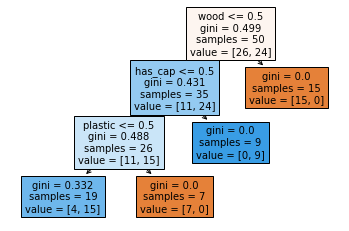

In [4]:
from sklearn.tree import plot_tree
plot_tree(dt, feature_names=X.columns, filled=True);

## How does a decision tree make decisions?

There are two available cost functions that a decision tree can use:
1. The Gini Index
2. Entropy

### Gini Index

$Gini Index = 1 – \sum_{j}p_{j}^{2}$

j = A class label

p = The proportion of observations in the split for the j class label

Let's turn this into a function!

In the cell below we create a `gini_index` function that:
1. receives a pandas series
2. calculates the proportions for each class in the series
3. Calculates and returns the gini index

In [13]:
# Your code here
def gini_index(series):
    proportions = series.value_counts(normalize = True)
    proportions = proportions ** 2
    gini = 1 - proportions.sum()
    return gini

**Let's use our gini index function to calculate the gini score for each split of our decision tree!**

First we calculate the gini score for whether or not the utensil is made of wood. 

In [14]:
# Collect the index for observations 
# that are made of wood
wood_index = X[X.wood > 0.5].index

# Collect the index for observations 
# that are not made of wood
not_wood_index = X[X.wood <= 0.5].index

# Collect the labels for both groups
wood_labels = y.loc[wood_index]
not_wood_labels = y.loc[not_wood_index]

# Calculate the gini score for each!
wood_gini = gini_index(wood_labels)
not_wood_gini = gini_index(not_wood_labels)

print(f'Wood Gini: {wood_gini}')
print(f'Not Wood Gini: {not_wood_gini}')

Wood Gini: 0.0
Not Wood Gini: 0.43102040816326526


In [19]:
wood_labels.value_counts(normalize = True)

0    1.0
Name: type, dtype: float64

Next, we take the observations that are not made of wood, and split them according to whether or not they have a cap. 

In [21]:
# Collect the index for observations 
# that are not made of wood and have a cap
mask = (X.loc[not_wood_index].has_cap > 0.5)
no_wood_with_cap_index = (X.loc[not_wood_index][mask]).index

# Collect the index for observations 
# that are not made of wood and do not have a cap
mask = (X.loc[not_wood_index].has_cap <= 0.5)
no_wood_no_cap_index = (X.loc[not_wood_index][mask]).index

# Collect class labels for both groups
no_wood_with_cap_labels = y.loc[no_wood_with_cap_index]
no_wood_no_cap_labels = y.loc[no_wood_no_cap_index]

# Calculate the gini score for each!
no_wood_with_cap_gini = gini_index(no_wood_with_cap_labels)
no_wood_no_cap_gini = gini_index(no_wood_no_cap_labels)

print(f'No Wood With Cap Gini: {no_wood_with_cap_gini}')
print(f'No Wood No Cap Gini: {no_wood_no_cap_gini}')

No Wood With Cap Gini: 0.0
No Wood No Cap Gini: 0.48816568047337283


Now, we take the observations that are not made of wood and do not have have a cap, and we split them according to whether or not they are made of metal. 

In [27]:
# Collect the index for observations 
# that are not made of wood and have a cap


# Collect the index for observations 
# that are not made of wood and do not have a cap


# Collect class labels for both groups


# Calculate the gini score for each!


print(f'No Wood No Cap Metal Gini: {}')
print(f'No Wood No Cap No Metal Gini: {}')

No Wood No Cap Metal Gini: 0.3324099722991689
No Wood No Cap No Metal Gini: 0.0


### How does Decision Tree decide on splits?

For every split, the decision tree:
1. Loops over every column
2. Splits the data according to every unique value in the column
3. Calculates the gini score for every split
4. Returns the split that resulted in the best gini score.

In [27]:
def find_split(X, target, cost_function, best_score=.5):
    """
    Finds the split of the data that results in the best purity.
    
    X =             Pandas DataFrame
    
    target =        String. The name of the target column
    
    cost_function = Function that calculates the purity 
                    a Pandas Series of discrete data points
    
    best_score =    The score all other splits will be compared to.
                    If a score is found that is lower than best_score
                    The best score is set to the new metric.
                    Gini and Entropy both need to be minimized.
                    Gini's maximum = .5
                    Entropy maximum = 1
                    
    Returns: The best score and a tuple containing the column name
             And the value used for splitting. 
    """
    
    # Create a `best_split` variable and set it to None
    best_split = None


    # Create a variable `columns` that is a list containing
    # All of the column names in the dataframe
    columns = list(X.columns)

    # Remove the target from the list of column names
    columns.remove(target)
    
    # Loop over the list of columns
    for column in columns:
        
        # Find all the unique values in the column
        unique = X[column].unique()

        # Loop over every unique value
        for val in unique:

            # Create two dataframes. 
            # 1) `split_1` Split the dataframe so it contains
                        #. all observations where the column value
                        #. is less than or equal to the unique value
            # 2) `split_2` Split the dataframe so it contains
                          # all observations where the column value
                          # is greater than or equal to the unique value
            split_1 = X[X[column] <= val]
            split_2 = X[X[column] >= val]

            # Calculate the gini score for each split
            split_1_score = cost_function(split_1[target])
            split_2_score = cost_function(split_2[target])

            # Add the gini scores together
            score = split_1_score + split_2_score

            # If the score if less than the best score
            # set the best score to the score we have 
            # calculated and set the best split
            # to the name of the column and the value
            # we split on
            if score < best_score:
                best_score = score
                best_split = (column, val)

    # Return the best_score and best_split        
    return best_score, best_split
    
best_score, best_split = find_split(utensils, 'type', gini_index)
print(f'Best Score: {best_score}')
print(f'Best Split: {best_split}')

Best Score: 0.4992
Best Split: ('wood', 1)


### Entropy

$Entropy = – \sum_{j}p_{j} \cdot log_{2} \cdot p_{j}$

In [28]:
def entropy(series):
    proportions = series.value_counts(normalize=True)
    proportions = proportions * np.log2(proportions)
    proportions = proportions.sum()
    return -proportions

Let's run the code above, and replace `gini_index` with our `entropy` function

In [29]:
best_score, best_split = find_split(utensils, 'type', entropy, best_score=1)            
print(f'Best Score: {best_score}')
print(f'Best Split: {best_split}')

Best Score: 0.9988455359952018
Best Split: ('wood', 1)


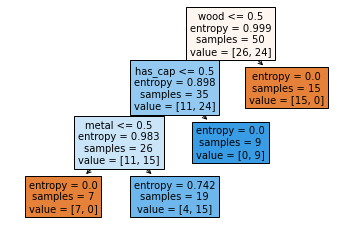

In [30]:
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X,y)
plot_tree(dt, feature_names=X.columns, filled=True);

What is the difference between gini and entropy? 

Due to time, this question is slightly out of scope for this lesson. For a good explanation, see [this article](https://quantdare.com/decision-trees-gini-vs-entropy/)

The TL;DR is that entropy is more computationally expensive (the model takes longer to fit to data) than gini, but entropy tends to perform slightly better in terms of accuracy than gini. 

## Using Sklearn

In [31]:
df = pd.read_csv('https://gist.githubusercontent.com/michhar/2dfd2de0d4f8727f873422c5d959fff5/raw/fa71405126017e6a37bea592440b4bee94bf7b9e/titanic.csv')

In [32]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [37]:
# Import decision tree classifier
from sklearn.tree import DecisionTreeClassifier
# Other imports:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [39]:
# Select the features I'd like to use
features = ['Age', 'Sex', 'Pclass', 'Fare']
# Drop null values for according to selected features
X = df.dropna(subset = features)
# Isolate the target
y = X.Survived
# Isolate the predictors
X = X[features]
# Instantiate a label encoder
encoder = LabelEncoder()
# Fit the label encoder to the categorical data
encoder.fit(X['Sex'])
# Transform the categorical data
X['Sex'] = encoder.transform(X['Sex'])

# Create a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2021)

# Fit the decision tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

Let's score the decision tree model on the training data

In [40]:
dt.score(X_train,y_train)

0.9887850467289719

Let's score the decision tree model on testing data

In [41]:
dt.score(X_test,y_test)

0.7262569832402235

Plot the decision tree

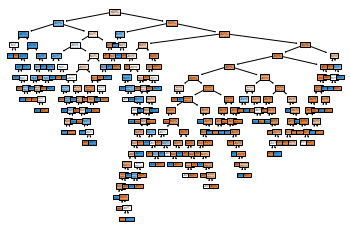

In [42]:
plot_tree(dt, feature_names=X.columns, filled=True);

### Tune the model!

In [43]:
second_model = DecisionTreeClassifier(max_depth=5, 
                                      min_samples_split = 10, 
                                      max_leaf_nodes=100)

In [44]:
second_model.fit(X_train, y_train)
second_model.score(X_train,y_train)

0.8373831775700935

In [45]:
second_model.score(X_test, y_test)

0.7541899441340782

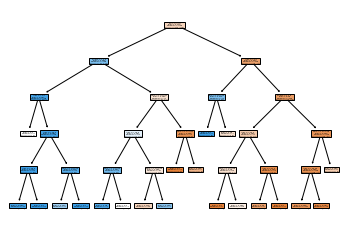

In [46]:
plot_tree(second_model, feature_names=X.columns, filled=True);

### Grid Search

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
grid_params = {'min_samples_split' : [6,10,14],
               'max_depth': [2,4, 5],
               'max_leaf_nodes': [40,80,100]}

grid_search = GridSearchCV(dt, grid_params, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 5],
                         'max_leaf_nodes': [40, 80, 100],
                         'min_samples_split': [6, 10, 14]},
             scoring='accuracy')

In [49]:
grid_search.score(X_train, y_train)

0.8149532710280374

In [50]:
grid_search.score(X_test, y_test)

0.7653631284916201

In [51]:
grid_search.best_params_

{'max_depth': 2, 'max_leaf_nodes': 40, 'min_samples_split': 6}